In [ ]:
import os
import shutil

base_dir = "/content/tiny-imagenet-200"
val_dir = os.path.join(base_dir, "val")
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

# Read annotations
with open(ann_file) as f:
    annotations = [line.strip().split('\t') for line in f]

# Create class folders and move images
for img, cls, *_ in annotations:
    cls_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    shutil.move(
        os.path.join(images_dir, img),
        os.path.join(cls_dir, img)
    )

os.rmdir(images_dir)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfla
import tensorflow.keras.models as tfm
import tensorflow.keras.optimizers as tfo
import tensorflow.keras.losses as tflo
import matplotlib.pyplot as plt

In [ ]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int"
)

# load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [ ]:
def compute_mean(dataset):
  total = tf.zeros([3], dtype=tf.float32)
  count = 0

  for images, _ in dataset:
    images = tf.cast(images, tf.float32)
    pixels = tf.reshape(images, [-1, 3])
    total += tf.reduce_sum(pixels, axis=0)
    count += tf.shape(pixels)[0]

  return total / tf.cast(count, tf.float32)

In [ ]:
mean = compute_mean(train_ds)
train_ds = train_ds.map(lambda x, y: (x - mean, y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x - mean, y))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
bias_init = tf.keras.initializers.Zeros()

In [ ]:
def build_vgg11():
  inputs = tfla.Input(shape=(224, 224, 3))

  # conv block 1
  x = tfla.Conv2D(64, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(inputs)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

  # conv block 2
  x = tfla.Conv2D(128, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

  # conv block 3
  x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

  # conv block 4
  x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

  # conv block 5
  x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

  x = tfla.Flatten()(x)

  # FC 6
  x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                  bias_initializer=bias_init)(x)
  x = tfla.Dropout(0.3)(x)

  # FC 7
  x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                  bias_initializer=bias_init)(x)
  x = tfla.Dropout(0.3)(x)

  #FC 8
  outputs = tfla.Dense(200, kernel_initializer=kernel_init,
                  bias_initializer=bias_init)(x)

  return tfm.Model(inputs, outputs)

In [ ]:
vgg11 = build_vgg11()
vgg11.load_weights("vgg11.weights.h5")
vgg11.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 28, 28, 512)    │             

 Total params: 129,596,744 (494.37 MB)

 Trainable params: 129,591,240 (494.35 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
inputs = tfla.Input(shape=(224, 224, 3))

# conv block 1
x = tfla.Conv2D(64, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(inputs)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(64, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 2
x = tfla.Conv2D(128, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(128, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 3
x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(256, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 4
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

# conv block 5
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.Conv2D(512, 3, 1, kernel_initializer=kernel_init,
                bias_initializer=bias_init, padding="same")(x)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPooling2D(pool_size=2, strides=2)(x)

x = tfla.Flatten()(x)

# FC 6
x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)
x = tfla.Dropout(0.3)(x)

# FC 7
x = tfla.Dense(4096, activation="relu", kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)
x = tfla.Dropout(0.3)(x)

#FC 8
outputs = tfla.Dense(200, kernel_initializer=kernel_init,
                bias_initializer=bias_init)(x)

vgg16 = tfm.Model(inputs, outputs)

In [ ]:
for l11, l16 in zip(vgg11.layers, vgg16.layers):
  if l11.get_weights() and l16.get_weights():
    if(all(w1.shape == w2.shape for w1, w2 in zip(l11.get_weights(), l16.get_weights()))):
      l16.set_weights(l11.get_weights())

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9,
    weight_decay=5e-4,
)

vgg16.compile(
    optimizer=optimizer,
    loss=tflo.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
def lr_schedule(epoch, lr):
  if(epoch < 20):
    return 0.001
  else:
    if(epoch < 40):
      return 0.0001
    else:
      if(epoch < 60):
        return 0.00001
      else:
        return 0.000001

In [ ]:
vgg16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 256)    │       590,08

 Total params: 135,096,840 (515.35 MB)

 Trainable params: 135,088,392 (515.32 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [ ]:
x, y = next(iter(train_ds))

with tf.GradientTape() as tape:
  preds = vgg16(x, training = True)
  loss = tflo.SparseCategoricalCrossentropy(from_logits=True)(y, preds)

grads = tape.gradient(loss, vgg16.trainable_weights)
for grad, var in zip(grads, vgg16.trainable_weights):
  tf.print(var.name, tf.reduce_mean(tf.abs(grad)))

kernel 0.21220006
bias 2.23429026e-07
gamma 0.0501026884
beta 0.078769505
kernel 0.228220433
bias 2.67883297e-06
gamma 0.048260875
beta 0.0441390947
kernel 0.129980505
bias 1.32401362e-06
gamma 0.0241257939
beta 0.0278627239
kernel 0.0751354322
bias 3.39183316e-07
gamma 0.0224009939
beta 0.0204309672
kernel 0.0468610749
bias 1.68512031e-07
gamma 0.0131985005
beta 0.0130134784
kernel 0.0276061352
bias 1.22961524e-07
gamma 0.0101087214
beta 0.0104599427
kernel 0.0228513181
bias 5.31190381e-08
gamma 0.00821705163
beta 0.00560870394
kernel 0.0137300985
bias 2.32652297e-08
gamma 0.00566240307
beta 0.00526453275
kernel 0.00804267079
bias 1.56186672e-08
gamma 0.00430665538
beta 0.00414221128
kernel 0.00667905528
bias 1.02326254e-08
gamma 0.00379644264
beta 0.00228613638
kernel 0.005565
bias 4.22792468e-09
gamma 0.00300051714
beta 0.00273638172
kernel 0.00464448147
bias 4.59590055e-09
gamma 0.00273535401
beta 0.00240052538
kernel 0.00390997622
bias 3.23780358e-09
gamma 0.00334838498
beta 0.002

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = vgg16.fit(
    train_ds,
    epochs=40,
    callbacks=[lr_callback]
)

print("\nevaluation\n")
vgg16.evaluate(test_ds)

Epoch 1/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 958s 294ms/step - accuracy: 0.0365 - loss: 4.9606 - learning_rate: 0.0010
Epoch 2/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 923s 295ms/step - accuracy: 0.1545 - loss: 3.8717 - learning_rate: 0.0010
Epoch 3/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 923s 295ms/step - accuracy: 0.2461 - loss: 3.2951 - learning_rate: 0.0010
Epoch 4/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.3152 - loss: 2.9104 - learning_rate: 0.0010
Epoch 5/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.3757 - loss: 2.5839 - learning_rate: 0.0010
Epoch 6/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.4363 - loss: 2.2959 - learning_rate: 0.0010
Epoch 7/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.4918 - loss: 2.0246 - learning_rate: 0.0010
Epoch 8/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.5467 - loss: 1.7694 - learning_rate: 0.0010
Epoch 9/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0.

[3.011944055557251, 0.503600001335144]

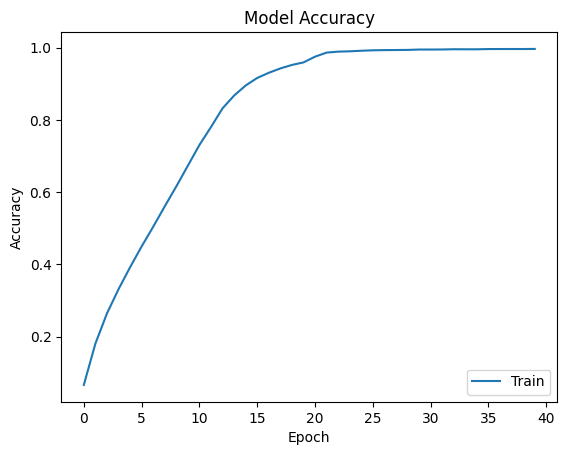

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()